# Domain Adaptive Fine-Tuning with FiQA dataset for MLM

Initialization - Set Runtime type as GPU

This Notebook is part of the final Thesis.

This Notebook explains the fine-tuning of the pre-trained Language models using the Financial Question Answering (FiQA) dataset. 

Code from the following repository is reused to create the Question Answer pair dataset from the FiQA challenge dataset - https://github.com/yuanbit/FinBERT-QA

The following models are fine tuned using the dataset and used for comparison. 
* Model 1 - "bert-base-uncased"
* Model 2 - "roberta-base"
* Model 3 - "finbert"

The Model class AutoModelForMaskedLM is used for fine tuning. 
https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForMaskedLM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Initialization

In [ ]:
# Restart Run time required
!pip install -U numpy -q

     |████████████████████████████████| 15.7 MB 4.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.4 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
!pip install datasets transformers -q

     |████████████████████████████████| 298 kB 4.2 MB/s 
     |████████████████████████████████| 3.3 MB 53.7 MB/s 
     |████████████████████████████████| 61 kB 613 kB/s 
     |████████████████████████████████| 1.1 MB 59.6 MB/s 
     |████████████████████████████████| 243 kB 64.7 MB/s 
     |████████████████████████████████| 132 kB 68.4 MB/s 
     |████████████████████████████████| 3.3 MB 52.2 MB/s 
     |████████████████████████████████| 895 kB 57.3 MB/s 
     |████████████████████████████████| 596 kB 66.5 MB/s 
     |████████████████████████████████| 160 kB 59.6 MB/s 
     |████████████████████████████████| 192 kB 72.6 MB/s 
     |████████████████████████████████| 271 kB 65.4 MB/s 


In [ ]:
import torch
import pickle
import csv
import regex as re
import pandas as pd
import math

In [ ]:
# To display using word wrap
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
# Utility Function - Show random elements
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=5):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

# FiQA Generate data for training

In [ ]:
FiQA_dir = "/content/drive/MyDrive/FinLitQA/FiQA"
query_df_path = FiQA_dir + "/" + "FiQA_train_question_final.tsv"
doc_df_path = FiQA_dir + "/" + "FiQA_train_doc_final.tsv"
querydoc_df_path = FiQA_dir + "/" + "FiQA_train_question_doc_final.tsv"

In [ ]:
query_df = pd.read_csv(query_df_path, sep="\t")
query_df = query_df[["qid", "question"]]
print (query_df.info())
query_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6648 entries, 0 to 6647
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   qid       6648 non-null   int64 
 1   question  6648 non-null   object
dtypes: int64(1), object(1)
memory usage: 104.0+ KB
None


,qid,question
0,0,What is considered a business expense on a bus...
1,1,Claiming business expenses for a business with...
2,2,Transferring money from One business checking ...
3,3,Having a separate bank account for business/in...
4,4,Business Expense - Car Insurance Deductible Fo...


In [ ]:
querydoc_df = pd.read_csv(querydoc_df_path, sep="\t")
querydoc_df = querydoc_df[["qid", "docid"]]
print (querydoc_df.info())
querydoc_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17110 entries, 0 to 17109
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   qid     17110 non-null  int64
 1   docid   17110 non-null  int64
dtypes: int64(2)
memory usage: 267.5 KB
None


,qid,docid
0,0,18850
1,1,14255
2,2,308938
3,3,296717
4,3,100764


In [ ]:
doc_df = pd.read_csv(doc_df_path, sep="\t")
print (doc_df.info())
doc_df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57638 entries, 0 to 57637
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  57638 non-null  int64 
 1   docid       57638 non-null  int64 
 2   doc         57600 non-null  object
 3   timestamp   57638 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.8+ MB
None


,Unnamed: 0,docid,doc,timestamp
0,0,3,I'm not saying I don't like the idea of on-the...,Oct 03 '12 at 14:56
1,1,31,So nothing preventing false ratings besides ad...,Sep 01 '17 at 13:36


In [ ]:
def pre_process(text):
    """Returns a lower-cased string with punctuations and special characters removed.
    Returns:
        processed_text: str
    ----------
    Arguments:
        text: str of answer or question text
    """
    text = str(text)
    # Substitute punctuations and special characters for a space
    x = re.sub('[…“”%!&"@#()\-\*\+,/:;<=>?@[\]\^_`{\}~]', ' ', text)
    # Remove periods
    y = re.sub('[\.\']', "", x)
    # Apply lower-case
    processed_text = y.lower()

    return processed_text

In [ ]:
doc_df['doc_clean'] = doc_df['doc'].apply(pre_process)
doc_df.head()

,Unnamed: 0,docid,doc,timestamp,doc_clean
0,0,3,I'm not saying I don't like the idea of on-the...,Oct 03 '12 at 14:56,im not saying i dont like the idea of on the j...
1,1,31,So nothing preventing false ratings besides ad...,Sep 01 '17 at 13:36,so nothing preventing false ratings besides ad...
2,2,56,You can never use a health FSA for individual ...,Jun 9 '14 at 17:37,you can never use a health fsa for individual ...
3,3,59,Samsung created the LCD and other flat screen ...,Dec 27 at 01:37,samsung created the lcd and other flat screen ...
4,4,63,Here are the SEC requirements: The federal sec...,Jul 14 '14 at 8:10,here are the sec requirements the federal sec...


## Create fiqa_doc dataset from doc column

In [ ]:
from datasets import load_dataset
from datasets import Dataset
fiqa_doc_df = pd.DataFrame(doc_df["doc_clean"])

Create Train, Test split for FIQA Doc column and write to text in Drive

In [ ]:
from sklearn.model_selection import train_test_split
fiqa_doc_train, fiqa_doc_valid = train_test_split(fiqa_doc_df, test_size= 0.2)

In [ ]:
# Write fiqa_doc to text
fiqa_doc_path = '/content/drive/MyDrive/FinLitQA/FiQA/fiqa_doc.txt'
fiqa_doc_train_path = '/content/drive/MyDrive/FinLitQA/FiQA/fiqa_doc_train.txt'
fiqa_doc_valid_path = '/content/drive/MyDrive/FinLitQA/FiQA/fiqa_doc_valid.txt'

fiqa_doc_df.to_csv(fiqa_doc_path, index=False, header=False, sep="\t")
fiqa_doc_train.to_csv(fiqa_doc_train_path ,index=False,header=False, sep="\t")
fiqa_doc_valid.to_csv(fiqa_doc_valid_path ,index=False,header=False, sep="\t")

In [ ]:
print (fiqa_doc_df.shape, fiqa_doc_train.shape, fiqa_doc_valid.shape)

(57638, 1) (46110, 1) (11528, 1)


Create and load Hugging face Dataset from fida_doc_df

In [ ]:
from datasets import load_dataset
# fiqa_doc = Dataset.from_pandas(fiqa_doc_df)
fiqa_doc = load_dataset("text", data_files={"train": fiqa_doc_train_path, 
                                            "validation": fiqa_doc_valid_path})
fiqa_doc

Using custom data configuration default-ee19480c4e5409a5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Dataset text downloaded and prepared to /root/.cache/huggingface/datasets/text/default-ee19480c4e5409a5/0.0.0/e16f44aa1b321ece1f87b07977cc5d70be93d69b20486d6dacd62e12cf25c9a5. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 46116
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 11528
    })
})

In [ ]:
show_random_elements(fiqa_doc["train"])

## Create Question answer pair from FIQA dataset

In [ ]:
#!git clone https://github.com/yuanbit/FinBERT-QA
%cd /content/drive/MyDrive/FinBERT-QA
from src.utils import *

/content/drive/MyDrive/FinBERT-QA


In [ ]:
!pip install pyserini

     |████████████████████████████████| 75.5 MB 7.8 kB/s 
     |████████████████████████████████| 1.1 MB 61.1 MB/s 
     |████████████████████████████████| 13.5 MB 22.2 MB/s 
     |████████████████████████████████| 1.2 MB 72.4 MB/s 
     |████████████████████████████████| 4.8 MB 72.5 MB/s 
     |████████████████████████████████| 188 kB 73.0 MB/s 


In [ ]:
!pip install faiss-cpu --no-cache

     |████████████████████████████████| 8.4 MB 10.5 MB/s 


In [ ]:
from pyserini.search import SimpleSearcher

In [ ]:
!python3 src/generate_data-Copy1.py --query_path data/raw/FiQA_train_question_final.tsv \
                             --label_path data/raw/FiQA_train_question_doc_final.tsv


Generating training set...

Generating validation set...

Generating test set...

Done. The pickle files are saved in /content/drive/My Drive/FinBERT-QA/data/data_pickle


In [ ]:
# Collection of answers - docid, text
collection = pd.read_csv("/content/drive/MyDrive/FinBERT-QA/retriever/answer_collection.tsv", sep="\t", header=None)
collection = collection.rename(columns={0: 'docid', 1: 'doc'})
# Questions - qid, text
query_df = pd.read_csv("/content/drive/MyDrive/FinBERT-QA/data/raw/FiQA_train_question_final.tsv", sep="\t")
queries = query_df[['qid', 'question']]

# List of empty docs
empty_docs = load_pickle('data/id_to_text/empty_docs.pickle')

# docid to text mapping
docid_to_text = load_pickle('data/id_to_text/docid_to_text.pickle')
# qid to text mapping
qid_to_text = load_pickle('data/id_to_text/qid_to_text.pickle')

In [ ]:
# Load and process dataset
dataset = pd.read_csv("/content/drive/MyDrive/FinBERT-QA/data/raw/FiQA_train_question_doc_final.tsv", sep="\t")
dataset = dataset[["qid", "docid"]]
dataset = dataset[~dataset['docid'].isin(empty_docs)]
dataset['question'] = dataset['qid'].apply(lambda x: qid_to_text[x])
dataset['answer'] = dataset['docid'].apply(lambda x: docid_to_text[x])

In [ ]:
dataset.head(5)

,qid,docid,question,answer
0,0,18850,What is considered a business expense on a bus...,The IRS Guidance pertaining to the subject. I...
1,1,14255,Claiming business expenses for a business with...,Yes you can claim your business deductions if ...
2,2,308938,Transferring money from One business checking ...,You should have separate files for each of the...
3,3,296717,Having a separate bank account for business/in...,Having a separate checking account for the bus...
4,3,100764,Having a separate bank account for business/in...,"You don't specify which country you are in, so..."


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17072 entries, 0 to 17109
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   qid       17072 non-null  int64 
 1   docid     17072 non-null  int64 
 2   question  17072 non-null  object
 3   answer    17072 non-null  object
dtypes: int64(2), object(2)
memory usage: 666.9+ KB


In [ ]:
def add_ques_token(string):
    question = string + " [SEP] "
    return question

In [ ]:
# Concatenate question and answer with a separator
dataset['question'] = dataset['question'].apply(add_ques_token)
dataset['seq'] = dataset['question'] + dataset['answer']
dataset.head(2)

,qid,docid,question,answer,seq
0,0,18850,What is considered a business expense on a bus...,The IRS Guidance pertaining to the subject. I...,What is considered a business expense on a bus...
1,1,14255,Claiming business expenses for a business with...,Yes you can claim your business deductions if ...,Claiming business expenses for a business with...


In [ ]:
fiqa_pair_df = dataset[['seq']]

fiqa_pair_df.at[17079, "seq"]

'How do you save money on clothes and shoes for your family? [SEP] I look ahead for sizes.  I was at the thrift store and saw a good condition, good brand winter coat that will likely fit my daughter next year, so I bought it.  I also bought a snowsuit my baby can wear when he\'s 6 months (~5 months pregnant now).  When it starts getting cold next fall, I\'ll be set, rather than wasting time and money running around town trying to find winter gear.  This applies for any regular stores you visit (Costco, thrift stores, kids resale stores, etc): look for clearance/discounted kids clothes in the next few sizes up, even off-season.   This works especially well for basics you need lots of (PJs, socks, etc) and more expensive things where you don\'t want to be desperate when shopping for them. You\'re always "buying low."'

In [ ]:
fiqa_pair_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17072 entries, 0 to 17109
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   seq     17072 non-null  object
dtypes: object(1)
memory usage: 906.8+ KB


In [ ]:
%cd /content/drive/MyDrive/FinLitQA/FiQA

/content/drive/MyDrive/FinLitQA/FiQA


Create Train, Validation split from fiqa_pair_df dataset

In [ ]:
from sklearn.model_selection import train_test_split
fiqa_pair_train, fiqa_pair_valid = train_test_split(fiqa_pair_df, test_size=0.2)

In [ ]:
# Write data to file
# Created three new text files in the FinLitQA/FiQA folder 
# fiqa_pair.txt , fiqa_pair_train.txt, fiqa_pair_valid.txt
 
fiqa_pair_path = '/content/drive/MyDrive/FinLitQA/FiQA/fiqa_pair.txt'
fiqa_pair_train_path = '/content/drive/MyDrive/FinLitQA/FiQA/fiqa_pair_train.txt'
fiqa_pair_valid_path = '/content/drive/MyDrive/FinLitQA/FiQA/fiqa_pair_valid.txt'

fiqa_pair_df.to_csv(fiqa_pair_path ,index=False,header=False, sep="\t", quoting=csv.QUOTE_NONE)
fiqa_pair_train.to_csv(fiqa_pair_train_path, index=False,header=False, sep="\t", quoting=csv.QUOTE_NONE)
fiqa_pair_valid.to_csv(fiqa_pair_valid_path, index=False,header=False, sep="\t", quoting=csv.QUOTE_NONE)

In [ ]:
print (fiqa_pair_df.shape, fiqa_pair_train.shape, fiqa_pair_valid.shape)

(17072, 1) (13657, 1) (3415, 1)


# Prepare dataset for Training

In [ ]:
from datasets import load_dataset

fiqa_pair_path = '/content/drive/MyDrive/FinLitQA/FiQA/fiqa_pair.txt'
fiqa_pair_train_path = '/content/drive/MyDrive/FinLitQA/FiQA/fiqa_pair_train.txt'
fiqa_pair_valid_path = '/content/drive/MyDrive/FinLitQA/FiQA/fiqa_pair_valid.txt'

fiqa_pair = load_dataset("text", data_files={"train": fiqa_pair_train_path,
                                             "validation": fiqa_pair_valid_path})

fiqa_pair

Using custom data configuration default-6531dc75a897b3a1


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Dataset text downloaded and prepared to /root/.cache/huggingface/datasets/text/default-6531dc75a897b3a1/0.0.0/e16f44aa1b321ece1f87b07977cc5d70be93d69b20486d6dacd62e12cf25c9a5. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 13657
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3415
    })
})

In [ ]:
show_random_elements(fiqa_pair["train"])

,text
0,"Are lottery tickets ever a wise investment provided the jackpot is large enough? [SEP] I think playing certain kinds of lottery is as economically sound as buying certain kinds of insurance. A lottery is an inverted insurance. Let me elaborate. We buy insurance for at least two reasons. The first one is clear: We pay a fee to protect ourselves from a risk which we don't want to (or cannot) bear. Although on average buying insurance is a loss, because we pay all the insurance's office buildings and employee's salaries, it still is a reasonable thing to do. (But it should also be clear that it is unreasonable to buy insurance for risks one could easily bear oneself.) The second reason to buy insurance is that it puts us at ease. We don't have to be afraid of theft or of a mistake we make which would make us liable or of water damage to our house. In that sense we buy freedom of sorrow for a fee, even if the damage wouldn't in fact ruin us. That's totally legitimate. Now I want to make the argument that buying a lottery ticket follows the same logic and is therefore not economically unreasonable at all. While buying a lottery ticket is on average a loss, it provides us with a chance to obtain an amount of money we would normally never get. (Eric Lippert made this argument already.) The lottery fee buys us a small chance of something very valuable, much as the insurance frees us from a small risk of something very bad. If we don't buy the ticket, we may have 0% chance of becoming (extremely) rich. If we buy one, we clearly have a chance > 0%, which can be considered an improvement. (Imagine you'd have a 0.0000001% chance to save the life of a loved one with a ticket who'd be 100% doomed otherwise. You'd bite.) Even the second argument, that an insurance puts us at ease, can be mirrored for lotteries. The chance to win something may provide entertainment in our otherwise dull everyday life. Considering that playing the lottery only makes sense for the chance to obtain more money than otherwise possible, one should avoid lotteries which have lots of smaller prizes because we are not really interested in those. (It would be more economical to save the money for smaller amounts.) We ideally only want lotteries which lean on the big money prizes."
1,"What is meant by “unexpected expenses” in my 401k plan? [SEP] IANAL, but it sounds like indemnification language. They are saying they have the option to charge expenses to participants if they would like. It should say explicitly (you mention that it does) who the 'default payer' is. Unexpected expenses could be anything that's not in the normal course of business. I know that doesn't help much, but some examples may be plan document restatements or admin expenses from plan failures/corrections. We have language in some of our PFDs that say in the absence of revenue-sharing a participants' share of expenses may be higher. Yes, 'from participant accounts' means they have the authority to deduct from your 401k account."
2,"Best return on investment for new home purchase [SEP] I encourage you to think of this home purchase decision as a chance to buy into a community that you want your children to grow up in. Try to find a place where you will be happy for the next 20 years, not just the next 2 or 7 years. In your situation, option 1 seems like a bad idea. It will create an obstacle to having children, instead of establishing a place for them to grow up in. Option 2 is close to ""buying a house on a layaway plan"". It offers the most financial flexibility. It also could result in the best long-term outcome, because you will buy in an established area, and you will know exactly what quality house you will have. But you and your fiancé need to ask yourselves some hard questions: Are you willing to put up with the mess and hassles of remodelling? Are you good at designing such projects? Can you afford to pay for the projects as they occur? Or if you need to finance them, can you get a 

In [ ]:
fiqa_pair["train"][10] , fiqa_pair["validation"][10]

({'text': "Work on the side for my wife's company [SEP] Depending on how much freelance work we're talking about you could set up a limited company, with you and your wife as directors. By invoicing all your work through the limited company (which could have many other benefits for you, an accountant/advisor would... well, advise...) it's the company earning the money, not you or her personally. You can then pay your wife up to £10,000 per year (as of writing this) without income tax kicking in. You would probably have to pay yourself a small amount to minimise exposure to HMRC's snooping, but possibly not... as far as I'm aware the rules do not state anything about working for free, for yourself - and I wouldn't worry about the ethics, you're already paying plenty into HMRC's bank account through your day job! Some good information here if you're interested: https://www.whitefieldtax.co.uk/web/psc-guide/pscguide-how-does-it-all-work-in-practice-salaries-and-dividends/"},
 {'text': 'Op

# MLM - Chunking and Tokenizing

In [ ]:
%cd /content/drive/MyDrive/FinLitQA

/content/drive/MyDrive/FinLitQA


In [ ]:
!mkdir model

mkdir: cannot create directory ‘model’: File exists


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Dec 13 16:44:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def chunk_examples(examples):
    chunks = []
    for sentence in examples['text']:
        chunks += [sentence[i:i + 500] for i in range(0, len(sentence), 500)]
    return {'chunks': chunks}

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["chunks"])

In [ ]:
# block_size = tokenizer.model_max_length
block_size = 128

In [ ]:
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
        # customize this part to your needs.
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
fiqa_chunked = fiqa_pair.map(chunk_examples, batched=True, remove_columns=["text"])
fiqa_chunked, fiqa_chunked['train'][:5]

  0%|          | 0/14 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

(DatasetDict({
    train: Dataset({
        features: ['chunks'],
        num_rows: 36900
    })
    validation: Dataset({
        features: ['chunks'],
        num_rows: 9158
    })
}),
 {'chunks': ['Why does a stock\'s price fluctuate so often, even when fresh news isn\'t available? [SEP] Investors are "forever" comparing the prices of stocks to other stocks. As others have pointed out, this is done faster and more frequently nowadays with high-speed computer programs. There may be no "fresh" news on stock A, but if there is fresh news on stock B (as there usually is), the news on B affects the COMPARISON with stock A. That could be what causes trading in stock A that has "no news."',
   "New car: buy with cash or 0% financing [SEP] Cash price is $22,500. Financed, it's the same thing (0% interest) but you pay a $1500 fee. 1500/22500 = 6.6%. Basically the APR for your loan is 1.1% per year but you are paying it all upfront. Opportunity cost: If you take the $22,500 you plan to pay fo

# Language Modeling for Multiple models

## Common Functions

* Model 1 - "bert-base-uncased"
* Model 2 - "roberta-base"
* Model 3 - "finbert"

In [ ]:
# Import from Transformers

from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import AutoTokenizer
from transformers import AutoModelForMaskedLM
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorForLanguageModeling

In [ ]:
# Function to Define the trainer
def trainer_from_args(model_dir, model_name, model, tokenizer, lm_datasets):
    '''Get the training arguments and define a trainer'''
    
    training_args = TrainingArguments(
        f"{model_dir}{model_name}",
        evaluation_strategy = "steps",
        num_train_epochs=5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16, 
        learning_rate=2e-5,
        weight_decay=0.01, 
        logging_dir='./logs',
        seed=42,
        save_steps=1000,
        eval_steps=1000,
        load_best_model_at_end=True,
        save_total_limit=2
    )

    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=lm_datasets["train"],
        eval_dataset=lm_datasets["validation"],
        data_collator=data_collator,
        tokenizer=tokenizer
    )
    
    return trainer

In [ ]:
df_lmtrain_summary = pd.DataFrame()

def add_to_lmtrain_summary(df) :
    global df_lmtrain_summary 
    df_lmtrain_summary = df_lmtrain_summary.append(df,ignore_index=True)

In [ ]:
def evaluate_trainer(trainer, model_name):

    # Here we initialize the nodes that perform evaluation
    eval_results = trainer.evaluate()
    print (eval_results)
    print (f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

    df = pd.DataFrame.from_dict(eval_results, orient="index")
    df.columns = [model_name]
    results_df = df.transpose().reset_index()
    results_df['Perplexity'] = f"{math.exp(eval_results['eval_loss']):.2f}"
    add_to_lmtrain_summary(results_df)
  
    return(results_df)

## Model 1 - "bert-base-uncased"

In [ ]:
# Define the model checkpoint

model_checkpoint1 = "bert-base-uncased"

In [ ]:
# Define Tokenizer and Model

#Training Arguments - Pass training arguments and define trainer
model_dir='/content/drive/MyDrive/FinLitQA/model/fiqa/' 
model_n = model_checkpoint1.split("/")[-1] 
model_suffix = "-fiqa" 
model_name = f"{model_n}{model_suffix}"

print (model_dir, model_name)

# Tokenizer is defined here
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint1, use_fast=True)
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint1)

# Create language modeling datasets
fiqa_tokenized = fiqa_chunked.map(tokenize_function, batched=True, num_proc=4, remove_columns=["chunks"])

lm_datasets = fiqa_tokenized.map(group_texts, batched=True, batch_size=1000, num_proc=4)

# trainer is defined here 
trainer = trainer_from_args(model_dir, model_name, model, tokenizer, lm_datasets)

/content/drive/MyDrive/FinLitQA/model/fiqa/ bert-base-uncased-fiqa


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


This is the Training step and it will take time

In [ ]:
%%time
trainer.train()


***** Running training *****
  Num examples = 26823
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 8385


Step,Training Loss,Validation Loss
1000,2.351000,2.216430
2000,2.252100,2.135804
3000,2.195500,2.072918
4000,2.147800,2.056773
5000,2.111600,2.035064
6000,2.087100,2.001306
7000,2.059400,1.997049
8000,2.049500,1.979813


***** Running Evaluation *****
  Num examples = 6607
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/FinLitQA/model/fiqa/bert-base-uncased-fiqa/checkpoint-1000
Configuration saved in /content/drive/MyDrive/FinLitQA/model/fiqa/bert-base-uncased-fiqa/checkpoint-1000/config.json
Model weights saved in /content/drive/MyDrive/FinLitQA/model/fiqa/bert-base-uncased-fiqa/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/FinLitQA/model/fiqa/bert-base-uncased-fiqa/checkpoint-1000/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/FinLitQA/model/fiqa/bert-base-uncased-fiqa/checkpoint-1000/special_tokens_map.json
Deleting older checkpoint [/content/drive/MyDrive/FinLitQA/model/fiqa/bert-base-uncased-fiqa/checkpoint-2000] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 6607
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/FinLitQA/model/fiqa/bert-base-uncased-fiqa/checkpo

NameError: ignored

In [ ]:
import math

eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

***** Running Evaluation *****
  Num examples = 6607
  Batch size = 16


Perplexity: 7.36


In [ ]:
# Save the model

save_path_model1 = "/content/drive/MyDrive/FinLitQA/model/fiqa_final/bert-base-uncased-fiqa/"
trainer.save_model(save_path_model1)

# Evaluate the trainer and consolidate the results
# Calculate and add Perplexity to the evaluation results

evaluate_trainer(trainer, model_name)

Saving model checkpoint to /content/drive/MyDrive/FinLitQA/model/fiqa_final/bert-base-uncased-fiqa/
Configuration saved in /content/drive/MyDrive/FinLitQA/model/fiqa_final/bert-base-uncased-fiqa/config.json
Model weights saved in /content/drive/MyDrive/FinLitQA/model/fiqa_final/bert-base-uncased-fiqa/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/FinLitQA/model/fiqa_final/bert-base-uncased-fiqa/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/FinLitQA/model/fiqa_final/bert-base-uncased-fiqa/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 6607
  Batch size = 16


{'eval_loss': 1.9934914112091064, 'eval_runtime': 32.722, 'eval_samples_per_second': 201.913, 'eval_steps_per_second': 12.621, 'epoch': 5.0}
Perplexity: 7.34


,index,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,Perplexity
0,bert-base-uncased-fiqa,1.993491,32.722,201.913,12.621,5.0,7.34


In [ ]:
# Reload model and check
model = AutoModelForMaskedLM.from_pretrained(save_path_model1, local_files_only=True)
trainer.model = model.cuda()
eval_results = trainer.evaluate()
eval_results, f"{math.exp(eval_results['eval_loss']):.2f}"

loading configuration file /content/drive/MyDrive/FinLitQA/model/fiqa_final/bert-base-uncased-fiqa/config.json
Model config BertConfig {
  "_name_or_path": "/content/drive/MyDrive/FinLitQA/model/fiqa_final/bert-base-uncased-fiqa/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.13.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file /content/drive/MyDrive/FinLitQA/model/fiqa_final/bert-base-uncased-fiqa/pytorch_model.bin
All model checkpoint weights were 

({'epoch': 5.0,
  'eval_loss': 1.9794766902923584,
  'eval_runtime': 32.7092,
  'eval_samples_per_second': 201.992,
  'eval_steps_per_second': 12.626},
 '7.24')

In [ ]:
df_lmtrain_summary

,index,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,Perplexity
0,bert-base-uncased-fiqa,1.993491,32.722,201.913,12.621,5.0,7.34


## Model 2 - "roberta-base"

In [ ]:
# model_checkpoint2 

model_checkpoint2 = "roberta-base"

In [ ]:
# Training Arguments - Pass training arguments and define trainer

model.to('cuda');
model_dir='/content/drive/MyDrive/FinLitQA/model/fiqa/'
model_n = model_checkpoint2.split("/")[-1]
model_suffix = "-fiqa"
model_name = f"{model_n}{model_suffix}"

print (model_dir, model_name)

# Define Tokenizer and Model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint2, use_fast=True)
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint2)

# Create language modeling datasets
fiqa_tokenized = fiqa_chunked.map(tokenize_function, batched=True, num_proc=4, remove_columns=["chunks"])
lm_datasets = fiqa_tokenized.map(group_texts, batched=True, batch_size=1000, num_proc=4)

# trainer is defined here 
trainer = trainer_from_args(model_dir, model_name, model, tokenizer, lm_datasets)

/content/drive/MyDrive/FinLitQA/model/fiqa/ roberta-base-fiqa


Could not locate the tokenizer configuration file, will try to use the model config instead.
https://huggingface.co/roberta-base/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpjsbi24c0


Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

storing https://huggingface.co/roberta-base/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
creating metadata file for /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hid

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

storing https://huggingface.co/roberta-base/resolve/main/vocab.json in cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
creating metadata file for /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
https://huggingface.co/roberta-base/resolve/main/merges.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp51hquj48


Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

storing https://huggingface.co/roberta-base/resolve/main/merges.txt in cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
creating metadata file for /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
https://huggingface.co/roberta-base/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpj0yjsoi7


Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

storing https://huggingface.co/roberta-base/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
creating metadata file for /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
loading file https://huggingface.co/roberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

storing https://huggingface.co/roberta-base/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7
creating metadata file for /root/.cache/huggingface/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7
loading weights file https://huggingface.co/roberta-base/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7
All model checkpoint weights were used when initializing RobertaForMaskedLM.

All the weights of RobertaForMaskedLM were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use Robe

In [ ]:
%%time
trainer.train()

eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

***** Running training *****
  Num examples = 26854
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 8395


Step,Training Loss,Validation Loss
1000,1.784500,1.669465
2000,1.751100,1.634230
3000,1.703100,1.614257
4000,1.677300,1.602091
5000,1.660300,1.581412
6000,1.641000,1.562007
7000,1.624500,1.550163
8000,1.593100,1.563104


***** Running Evaluation *****
  Num examples = 6616
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/FinLitQA/model/fiqa/roberta-base-fiqa/checkpoint-1000
Configuration saved in /content/drive/MyDrive/FinLitQA/model/fiqa/roberta-base-fiqa/checkpoint-1000/config.json
Model weights saved in /content/drive/MyDrive/FinLitQA/model/fiqa/roberta-base-fiqa/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/FinLitQA/model/fiqa/roberta-base-fiqa/checkpoint-1000/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/FinLitQA/model/fiqa/roberta-base-fiqa/checkpoint-1000/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 6616
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/FinLitQA/model/fiqa/roberta-base-fiqa/checkpoint-2000
Configuration saved in /content/drive/MyDrive/FinLitQA/model/fiqa/roberta-base-fiqa/checkpoint-2000/config.json
Model weights saved in /content/drive/MyDrive/Fi

Perplexity: 4.75
CPU times: user 46min 5s, sys: 53.3 s, total: 46min 58s
Wall time: 47min 42s


In [ ]:
# Save the model

save_path_model2 = "/content/drive/MyDrive/FinLitQA/model/fiqa_final/roberta-base-fiqa/"
trainer.save_model(save_path_model2)

# Evaluate the trainer and consolidate the results
# Calculate and add Perplexity to the evaluation results

evaluate_trainer(trainer, model_name)

Saving model checkpoint to /content/drive/MyDrive/FinLitQA/model/fiqa_final/roberta-base-fiqa/
Configuration saved in /content/drive/MyDrive/FinLitQA/model/fiqa_final/roberta-base-fiqa/config.json
Model weights saved in /content/drive/MyDrive/FinLitQA/model/fiqa_final/roberta-base-fiqa/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/FinLitQA/model/fiqa_final/roberta-base-fiqa/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/FinLitQA/model/fiqa_final/roberta-base-fiqa/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 6616
  Batch size = 16


{'eval_loss': 1.550885558128357, 'eval_runtime': 36.7812, 'eval_samples_per_second': 179.875, 'eval_steps_per_second': 11.256, 'epoch': 5.0}
Perplexity: 4.72


,index,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,Perplexity
0,roberta-base-fiqa,1.550886,36.7812,179.875,11.256,5.0,4.72


In [ ]:
# Reload model and check
model = AutoModelForMaskedLM.from_pretrained(save_path_model2, local_files_only=True)
trainer.model = model.cuda()

# Evaluate and check
eval_results = trainer.evaluate()
eval_results, f"{math.exp(eval_results['eval_loss']):.2f}"

loading configuration file /content/drive/MyDrive/FinLitQA/model/fiqa_final/roberta-base-fiqa/config.json
Model config RobertaConfig {
  "_name_or_path": "/content/drive/MyDrive/FinLitQA/model/fiqa_final/roberta-base-fiqa/",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.13.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file /content/drive/MyDrive/FinLitQA/model/fiqa_final/roberta-base-fiqa/pytorch_model.bin
All model checkpoint weights were

({'epoch': 5.0,
  'eval_loss': 1.557410717010498,
  'eval_runtime': 36.7604,
  'eval_samples_per_second': 179.976,
  'eval_steps_per_second': 11.262},
 '4.75')

In [ ]:
df_lmtrain_summary

,index,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,Perplexity
0,bert-base-uncased-fiqa,1.993491,32.7220,201.913,12.621,5.0,7.34
1,roberta-base-fiqa,1.550886,36.7812,179.875,11.256,5.0,4.72


## Model 3 - "finbert"

In [ ]:
# model_checkpoint3 

model_checkpoint3 = "ProsusAI/finbert"

In [ ]:
# Training Arguments - Pass training arguments and define trainer

model_dir='/content/drive/MyDrive/FinLitQA/model/finbert/'
model_n = model_checkpoint3.split("/")[-1]
model_suffix = "-fiqa"
model_name = f"{model_n}{model_suffix}"

print (model_dir, model_name)

/content/drive/MyDrive/FinLitQA/model/finbert/ finbert-fiqa


In [ ]:

# Define Tokenizer and Model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", use_fast=True)
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint3)

# Create language modeling datasets
fiqa_tokenized = fiqa_chunked.map(tokenize_function, batched=True, num_proc=4, remove_columns=["chunks"])
lm_datasets = fiqa_tokenized.map(group_texts, batched=True, batch_size=1000, num_proc=4)

# trainer is defined here 
trainer = trainer_from_args(model_dir, model_name, model, tokenizer, lm_datasets)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/758 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Some weights of the model checkpoint at ProsusAI/finbert were not used when initializing BertForMaskedLM: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMaskedLM were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
You should probably TRAIN this 

In [ ]:
%%time
trainer.train()

# evaluate trainer and check perplexity
eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

***** Running training *****
  Num examples = 26823
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 8385


Step,Training Loss,Validation Loss
1000,3.567900,3.231211
2000,3.053700,2.845521
3000,2.848000,2.650094
4000,2.710400,2.560780
5000,2.618000,2.485929
6000,2.568200,2.417186
7000,2.516300,2.403141
8000,2.493100,2.374210


***** Running Evaluation *****
  Num examples = 6607
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/FinLitQA/model/finbert/finbert-fiqa/checkpoint-1000
Configuration saved in /content/drive/MyDrive/FinLitQA/model/finbert/finbert-fiqa/checkpoint-1000/config.json
Model weights saved in /content/drive/MyDrive/FinLitQA/model/finbert/finbert-fiqa/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/FinLitQA/model/finbert/finbert-fiqa/checkpoint-1000/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/FinLitQA/model/finbert/finbert-fiqa/checkpoint-1000/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 6607
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/FinLitQA/model/finbert/finbert-fiqa/checkpoint-2000
Configuration saved in /content/drive/MyDrive/FinLitQA/model/finbert/finbert-fiqa/checkpoint-2000/config.json
Model weights saved in /content/drive/MyDrive/FinLitQA/model/f

Perplexity: 10.99
CPU times: user 42min 8s, sys: 33.5 s, total: 42min 41s
Wall time: 43min 10s


In [ ]:
# Save the model

save_path_model3 = "/content/drive/MyDrive/FinLitQA/model/fiqa_final/finbert-fiqa/"
trainer.save_model(save_path_model3)

# Evaluate the trainer and consolidate the results
# Calculate and add Perplexity to the evaluation results

evaluate_trainer(trainer, model_name)

Saving model checkpoint to /content/drive/MyDrive/FinLitQA/model/fiqa_final/finbert-fiqa/
Configuration saved in /content/drive/MyDrive/FinLitQA/model/fiqa_final/finbert-fiqa/config.json
Model weights saved in /content/drive/MyDrive/FinLitQA/model/fiqa_final/finbert-fiqa/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/FinLitQA/model/fiqa_final/finbert-fiqa/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/FinLitQA/model/fiqa_final/finbert-fiqa/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 6607
  Batch size = 16


{'eval_loss': 2.394272804260254, 'eval_runtime': 32.8521, 'eval_samples_per_second': 201.113, 'eval_steps_per_second': 12.571, 'epoch': 5.0}
Perplexity: 10.96


,index,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,Perplexity
0,finbert-fiqa,2.394273,32.8521,201.113,12.571,5.0,10.96


In [ ]:
# Reload model and check
model = AutoModelForMaskedLM.from_pretrained(save_path_model3, local_files_only=True)
trainer.model = model.cuda()

# Evaluate and check
eval_results = trainer.evaluate()
eval_results, f"{math.exp(eval_results['eval_loss']):.2f}"

loading configuration file /content/drive/MyDrive/FinLitQA/model/fiqa_final/finbert-fiqa/config.json
Model config BertConfig {
  "_name_or_path": "/content/drive/MyDrive/FinLitQA/model/fiqa_final/finbert-fiqa/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "positive",
    "1": "negative",
    "2": "neutral"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 1,
    "neutral": 2,
    "positive": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.13.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading

({'epoch': 5.0,
  'eval_loss': 2.3870279788970947,
  'eval_runtime': 32.8012,
  'eval_samples_per_second': 201.425,
  'eval_steps_per_second': 12.591},
 '10.88')

In [ ]:
df_lmtrain_summary

,index,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,Perplexity
0,finbert-fiqa,2.394273,32.8521,201.113,12.571,5.0,10.96


## Plot Perplexity

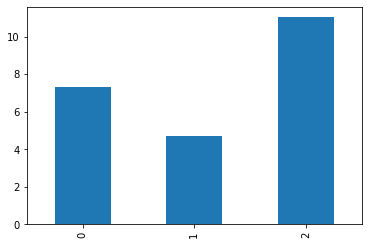

In [ ]:
import matplotlib.pyplot as plt

df_lmtrain_summary["Perplexity"].astype(float).plot(kind='bar')
plt.show()